# Encoder-decoder architecture

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [46]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
import numpy as np
import matplotlib.pyplot as plt
from vocab import Vocab
from sklearn.model_selection import train_test_split
from my_models import BasicModel
import torch
from IPython.display import clear_output
from transformers import FSMTForConditionalGeneration, FSMTTokenizer
from tqdm.notebook import tqdm
import copy

# Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions.

* Data will be tokenized with WordPunctTokenizer.

* Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

* One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [3]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
# !wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

In [52]:
def tokenize(x):
    return ' '.join(nltk_tokenizer.tokenize(x.lower()))


nltk_tokenizer = WordPunctTokenizer()

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

## Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

## Let's take a look at some sample data

In [5]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

assert len(data_inp) == len(data_out), 'Number of inp & out sequences must be the same'

print('Number of sequences: %s' % len(data_inp), end='\n\n')

train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=0.05,
                                                          random_state=0)
for i in range(3):
    print('Inp:', train_inp[i])
    print('Out:', train_out[i], end='\n\n')

Number of sequences: 50001

Inp: для гостей сервируется завтрак . кроме того , гости могут воспользоваться общей кухней .
Out: breakfast is provided and common kitchen facilities are featured .

Inp: в числе удобств всех номеров — мини - бар и телевизор со спутниковыми каналами , а в некоторых номерах есть гостиная зона и кондиционер .
Out: each comes with a minibar and satellite tv . some offer a seating area and air conditioning .

Inp: фитнес - центр гостиницы располагает 5 тренаж@@ ерами для фит@@ нес@@ а , а также мест@@ ами для игр и оборудованием для детей .
Out: the fitness centre of the hotel provides 5 types of fitness de@@ vi@@ ces and it offers games and special children - friendly equipment .



In [6]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [7]:
# Here's how you cast lines into ids and backwards
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print('Lines: %s' % batch_lines, end='\n\n')
print('Words to ids (0 = BOS, 1 = EOS):\n %s' % batch_ids, end='\n\n') # BOS = Begin Of Sentence
print('Back to words: %s' % batch_lines_restored)

Lines: ['имеется балкон .', 'гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

Words to ids (0 = BOS, 1 = EOS):
 tensor([[   0, 3487, 1870,   29,    1,    1,    1,    1],
        [   0, 2690, 2944, 1108,   29,    1,    1,    1],
        [   0, 2923, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6028, 2084,   29,    1,    1,    1,    1],
        [   0, 4928, 1870,   29,    1,    1,    1,    1]])

Back to words: ['имеется балкон .', 'гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


## Draw source and translation length distributions to estimate the scope of the task

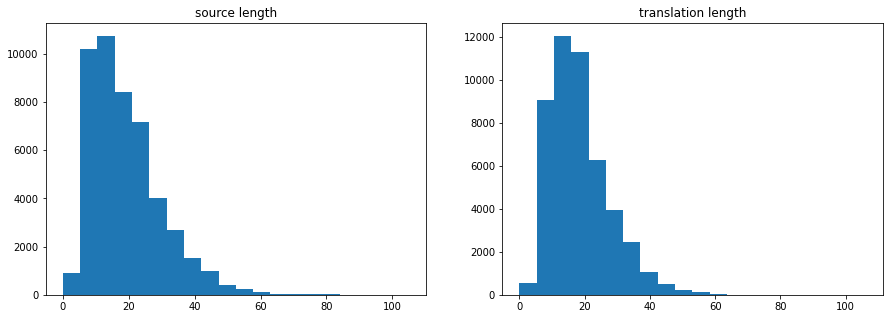

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

## Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything

In [9]:
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
device

'cuda:3'

## Debugging area

In [10]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

dummy_translations, dummy_states = model.translate_lines(train_inp[:2], device, max_len=25)
translations = '\n'.join([line for line in dummy_translations])
print('Translations without training:\n%s' % translations)

Translations without training:
skov@@ network lu@@ hammocks 0s rosa flo@@ colon imp@@ pin@@ necess@@ ugal polyana programme skov@@ yalta yalta ki@@ sters leg@@ dolphin holy twin york mal@@
skov@@ network lu@@ hammocks 0s rosa flo@@ colon imp@@ pin@@ necess@@ ugal polyana programme skov@@ yalta yalta ki@@ sters leg@@ dolphin holy twin york mal@@


## Training loss

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [11]:
from commons import compute_loss

In [12]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print('Loss: %s' % dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), 'Sorry for your loss'

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, 'Param %s received no gradients' % name

Loss: tensor(7.5685, device='cuda:3', grad_fn=<NegBackward>)


## Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [13]:
from commons import compute_bleu

In [14]:
# compute_bleu(model, dev_inp, dev_out)

## Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [15]:
from tqdm import tqdm

def train_model(model, n_iters=15000, batch_size=64, lr=1e-3, n_iters_break=500):
    metrics = {'train_loss': [], 'dev_bleu': [] }
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_weights = model.state_dict()
    best_bleu = -1
    best_step = -1
    with tqdm(range(n_iters)) as progress_bar:
        for i in progress_bar:
            step = len(metrics['train_loss']) + 1
            batch_ix = np.random.randint(len(train_inp), size=batch_size)
            batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
            batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

            opt.zero_grad()
            loss_t = compute_loss(model, batch_inp, batch_out)
            loss_t.backward()
            opt.step()

            metrics['train_loss'].append((step, loss_t.item()))
            if step % 100 == 0:
                bleu = compute_bleu(model, dev_inp, dev_out)
                metrics['dev_bleu'].append((step, bleu))

                if bleu > best_bleu:
                    best_bleu = bleu
                    best_step = step
                    best_weights = copy.deepcopy(model.state_dict())
                elif step - best_step >= n_iters_break:
                    break

                clear_output(wait=True)
                plt.figure(figsize=(12,4))
                for i, (name, history) in enumerate(sorted(metrics.items())):
                    plt.subplot(1, len(metrics), i + 1)
                    plt.title(name)
                    plt.plot(*zip(*history))
                    plt.grid()
                plt.show()

                print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
            
    model.load_state_dict(best_weights)
    return best_bleu

In [16]:
basic_model = BasicModel(inp_voc, out_voc).to(device)
%time train_model(basic_model, batch_size=128, lr=1e-3*5, n_iters=5000)

In [17]:
torch.save(basic_model.state_dict(), "basic_model")
basic_model.load_state_dict(torch.load("basic_model"))

In [34]:
def beam_research(model, inp, out, model_name, beam_min=1, beam_max=10):
    beam_range = range(beam_min, beam_max + 1)
    blue_scores = []

    for beam_size in beam_range:
        blue = compute_bleu(model, inp, out, beam_size=beam_size)
        blue_scores.append(blue)

    plt.figure(figsize=(7, 5))
    plt.plot(beam_range, blue_scores)
    plt.title('Beam search results for %s' % model_name)
    plt.xticks(beam_range)
    plt.xlabel('beam size')
    plt.ylabel('blue score')
    plt.show()

%time beam_research(basic_model, dev_inp, dev_out, 'basic model')

In [19]:
with torch.no_grad():
    for inp_line, trans_line in zip(dev_inp[::700], basic_model.translate_lines(dev_inp[::700], device, 2)[0]):
        print('Inp: %s' % inp_line.replace('@@ ', ''))
        print('Out: %s' % trans_line.replace('@@ ', ''))
        print()

## Simple Encoder-decoder model gets bleu 17.5, but quality of translation is so bad

# Model with attention

### Attention layer

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

## Seq2seq model with attention

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase. On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are alternative ways to wire attention into network and different kinds of attention. For example [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [20]:
from my_models import AttentiveModel

### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

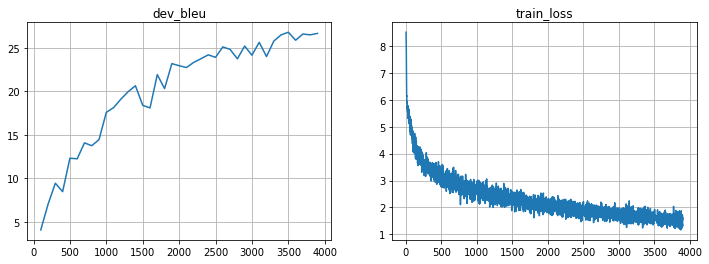

Mean loss=1.520


 27%|██▋       | 3999/15000 [12:35<34:37,  5.30it/s]  

CPU times: user 55min 32s, sys: 6.63 s, total: 55min 39s
Wall time: 12min 35s


26.810221729092447

In [36]:
attentive_model = AttentiveModel(inp_voc, out_voc, rnn_type='LSTM', bid=True).to(device)
%time train_model(attentive_model, lr=1e-3, batch_size=64)

In [22]:
# torch.save(attentive_model.state_dict(), "att_model")
# attentive_model.load_state_dict(torch.load("att_model"))

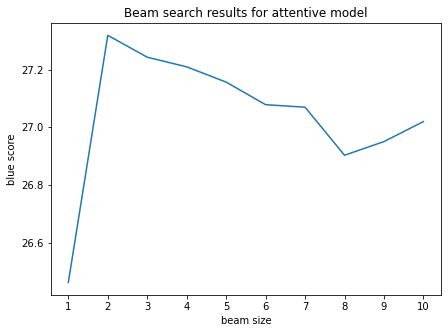

CPU times: user 33min 40s, sys: 2.59 s, total: 33min 42s
Wall time: 33min 41s


In [37]:
%time beam_research(attentive_model, dev_inp, dev_out, 'attentive model')

In [39]:
with torch.no_grad():
    for inp_line, trans_line in zip(dev_inp[::700], attentive_model.translate_lines(dev_inp[::700], device, 2)[0]):
        print('Inp: %s' % inp_line.replace('@@ ', ''))
        print('Out: %s' % trans_line.replace('@@ ', ''))
        print()

Inp: в распоряжении гостей караоке .
Out: a hairdryer is available .

Inp: рядом со зданием предоставляется бесплатная общественная парковка .
Out: free public parking is available nearby .

Inp: из отеля открывается вид на окружающие горы и пустыню .
Out: the hotel overlooks the surrounding mountains and the surrounding forest .

Inp: гости отеля могут посещать хорошо оборудованный фитнес - центр .
Out: guests have access to a well - equipped fitness centre .



In [42]:
compute_bleu(attentive_model, dev_inp, dev_out, beam_size=2)

27.318477918131574

## Attentive model gets bleu 27.3, it is significantly better then simple model and translation so better

## Transformer model

In [47]:
mname = "facebook/wmt19-ru-en"
tokenizer = FSMTTokenizer.from_pretrained(mname)
model = FSMTForConditionalGeneration.from_pretrained(mname).to('cuda:1')

Downloading:   0%|          | 0.00/776k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/639k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/396k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

In [57]:
from nltk.translate.bleu_score import corpus_bleu

def compute_blue_transformer(model, inp_lines, out_lines, bpe_sep='@@ '):
    inp = [line.replace(bpe_sep, '') for line in inp_lines]
    out = [line.replace(bpe_sep, '') for line in out_lines]
    translations = []
    for src in tqdm(inp):
        input_ids = tokenizer.encode(src, return_tensors="pt").to('cuda:1')
        outputs = model.generate(input_ids, num_beams=2)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        decoded = tokenize(decoded)
        translations.append(decoded)
        
    return corpus_bleu(
        [[ref.split()] for ref in out],
        [trans.split() for trans in translations],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

for inp_line in dev_inp[::700]:
    inp = inp_line.replace('@@ ', '')
    input_ids = tokenizer.encode(inp, return_tensors="pt").to('cuda:1')
    outputs = model.generate(input_ids)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    decoded = tokenize(decoded)
    print(inp)
    print(decoded)
    print()
    
compute_blue_transformer(model, dev_inp, dev_out)

в распоряжении гостей караоке .
karaoke is at guests " disposal .

рядом со зданием предоставляется бесплатная общественная парковка .
free public parking is available next to the building .

из отеля открывается вид на окружающие горы и пустыню .
the hotel overlooks the surrounding mountains and desert .

гости отеля могут посещать хорошо оборудованный фитнес - центр .
guests can use the hotel ' s well - equipped fitness centre .



  0%|          | 0/2501 [00:00<?, ?it/s]

33.72046665768791

In [2]:
# input = "я не люблю 23 февраля и иду в бгу!"
# input_ids = tokenizer.encode(input, return_tensors="pt")
# outputs = model.generate(input_ids)
# decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print(tokenize(decoded))